In [1]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl (38.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install imgaug

     ------------------------------------- 948.0/948.0 kB 12.0 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 17.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [30]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install imgaug

Defaulting to user installation because normal site-packages is not writeable
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
     ---------------------------------------- 1.4/1.4 MB 14.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


1. Importing all the necessary packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

show_final_history - For plotting the loss and accuracy of the training and validation datasets
plot_confusion_matrix - For plotting the percentage of true positives per class for a better feel of how the model predicted the data

In [2]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [3]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

2. Importing the Dataset: Uploading the images, Assigning labels [0,1] for classes

In [4]:
datasets = ['C:/Users/carol/OneDrive/Documents/DMML2/Imagery_of_Ships']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [5]:
def load_data():
    images, labels = [], []
    
    for dataset in datasets:
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(dataset,folder,file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass
    
    return (images, labels)
    pass

In [6]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:00<00:00, 1490.09it/s]


((4000, 48, 48, 3), (4000,))

3. Exploratory Data Analysis 

In [7]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


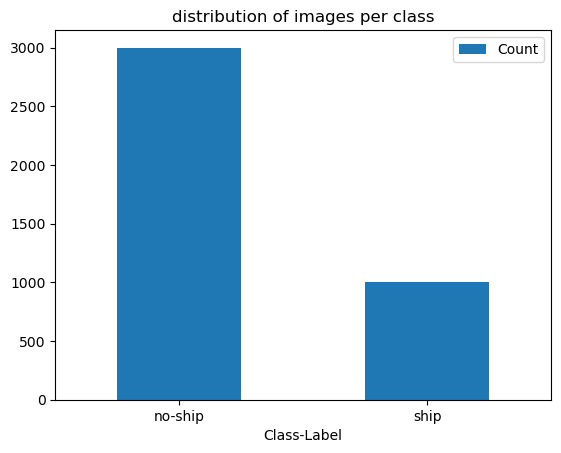

In [8]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

As it can be seen that the data is skewed towards the no-ship class with 75% of images belonging to that very specific class.

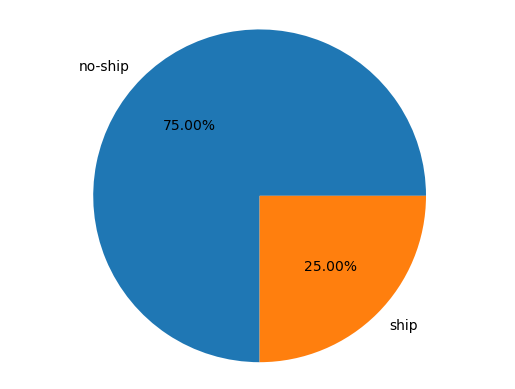

In [9]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

4. Data Preprocessing: Augmenting Images of Minority Class

In [10]:
AUGMENTATION = True

In [11]:
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass
    
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    
    return (augmented_images, augmented_labels)
    pass

In [12]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [13]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

0it [00:00, ?it/s]

4000it [00:01, 2204.77it/s] 


In [14]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

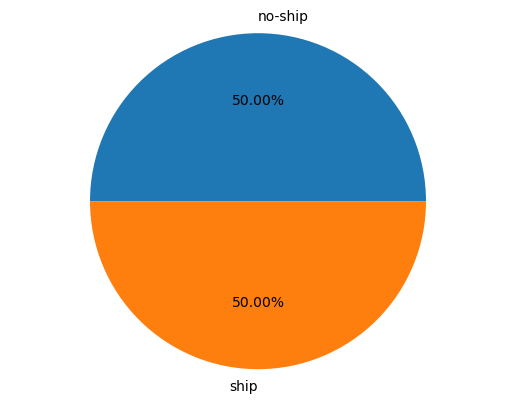

In [15]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

5. One Hot Encoding 

In [16]:
labels = to_categorical(labels)

6. Training, Validation and Testing


In [17]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

Spliting of data
70% - Training
20% - Validation
10% - Testing

In [18]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

6. If AUGMENTATION is set True, then the number of images per class is balanced. If AUGMENTATION is set to False, then compute the class weights given below and accordingly change the fit function of the Keras API when training.

In [19]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

7. Creation of Model

In [20]:
%pip install pydot

Defaulting to user installation because normal site-packages is not writeable
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    
    return X
    pass

In [22]:
def basic_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5))(X_input)
    
    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)
    
    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(128)(X)
    X = Activation("relu")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')
    
    return model
    pass


In [23]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [24]:
from tensorflow.keras.utils import plot_model


# Display the model summary
model.summary()

# Plot and display the model architecture
plot_model(model, show_shapes=True, to_file='basic_model.png')


Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 58, 58, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

8. Compiling the Model

In [25]:
learning_rate = 1e-3
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

9. Training model

In [27]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1, 
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50
261/262 [============================>.] - ETA: 0s - loss: 0.4112 - accuracy: 0.8071
Epoch 1: val_accuracy improved from -inf to 0.88250, saving model to model_weights.h5
262/262 [==============================] - 11s 36ms/step - loss: 0.4105 - accuracy: 0.8073 - val_loss: 0.2930 - val_accuracy: 0.8825
Epoch 2/50
  3/262 [..............................] - ETA: 8s - loss: 0.2691 - accuracy: 0.8824

C:\Users\carol\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/262 [============================>.] - ETA: 0s - loss: 0.2000 - accuracy: 0.9224
Epoch 2: val_accuracy improved from 0.88250 to 0.94917, saving model to model_weights.h5
262/262 [==============================] - 10s 36ms/step - loss: 0.1997 - accuracy: 0.9225 - val_loss: 0.1386 - val_accuracy: 0.9492
Epoch 3/50
261/262 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9453
Epoch 3: val_accuracy improved from 0.94917 to 0.95167, saving model to model_weights.h5
262/262 [==============================] - 8s 32ms/step - loss: 0.1474 - accuracy: 0.9452 - val_loss: 0.1187 - val_accuracy: 0.9517
Epoch 4/50
262/262 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9563
Epoch 4: val_accuracy improved from 0.95167 to 0.96667, saving model to model_weights.h5
262/262 [==============================] - 8s 29ms/step - loss: 0.1073 - accuracy: 0.9563 - val_loss: 0.0943 - val_accuracy: 0.9667
Epoch 5/50
262/262 [==============================] - ETA: 

10. Plotting Loss and Accuracy

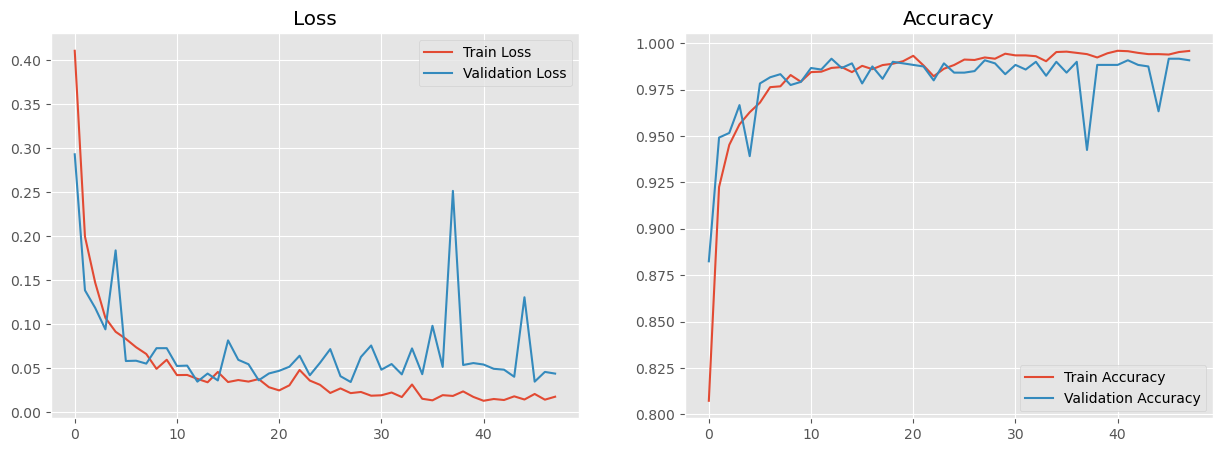

In [28]:
show_final_history(history)

11. Confusion Matrix for Validation dataset

In [29]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

38/38 [==============================] - 0s 9ms/step


(1200,)

<Figure size 640x480 with 0 Axes>

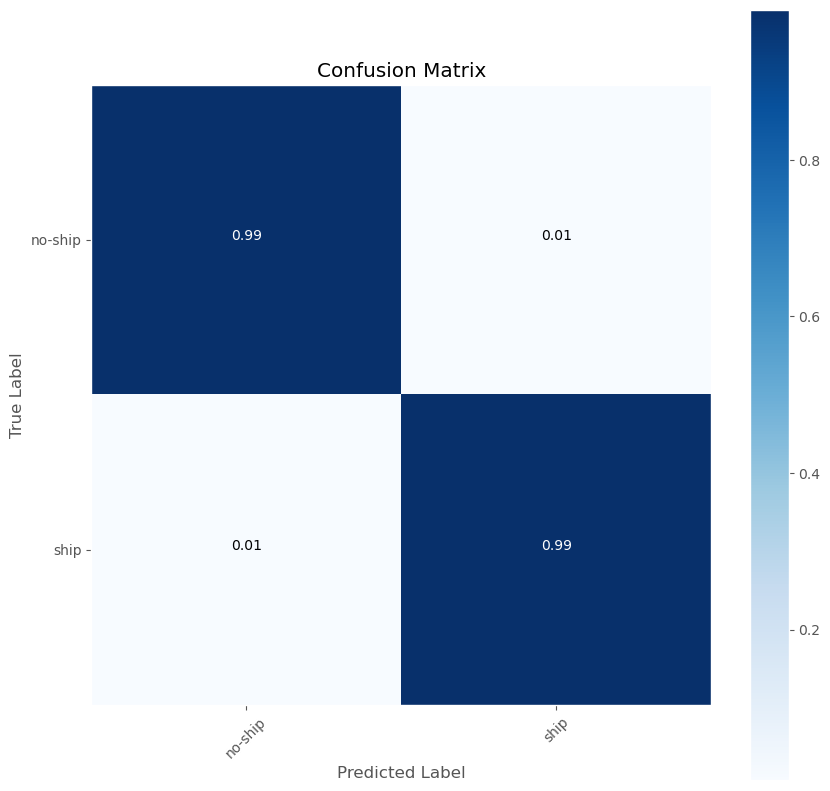

In [30]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

12. Confusion Matrix for Testing Dataset

In [31]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

19/19 [==============================] - 0s 10ms/step


(600,)

<Figure size 640x480 with 0 Axes>

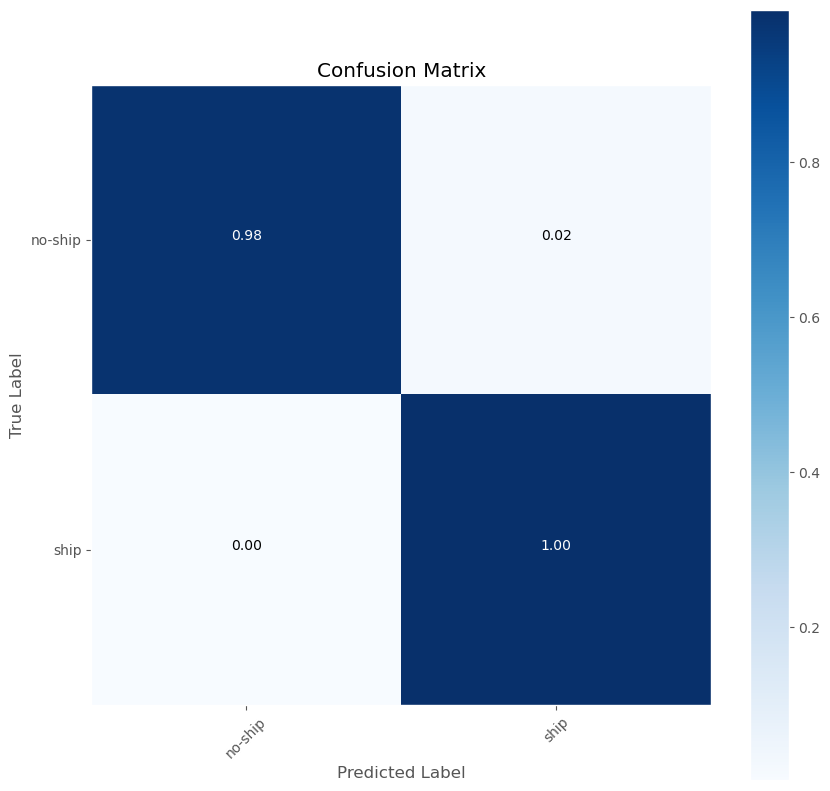

In [32]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

13. Checking the model

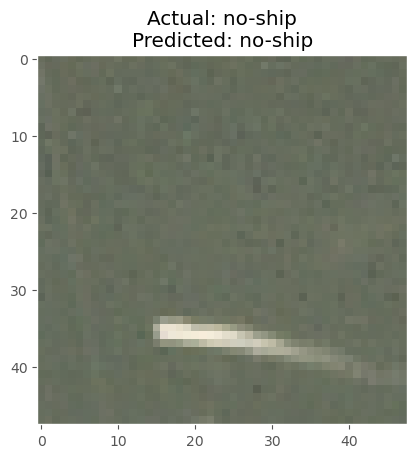

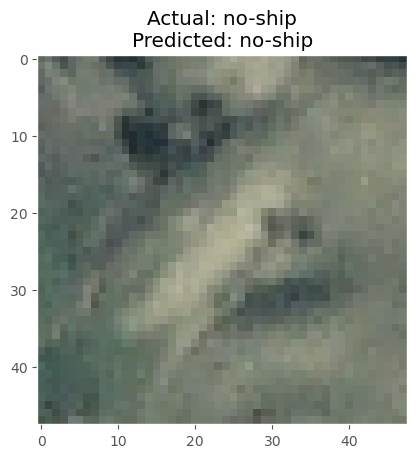

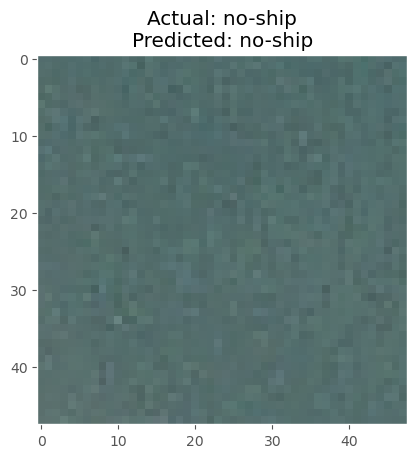

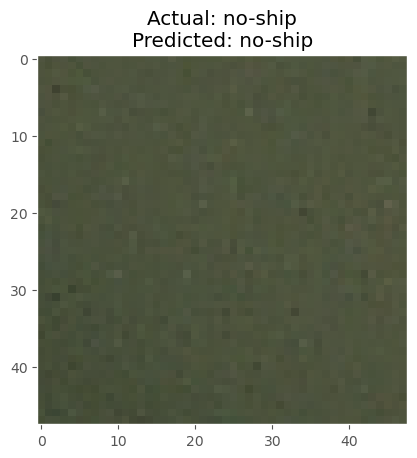

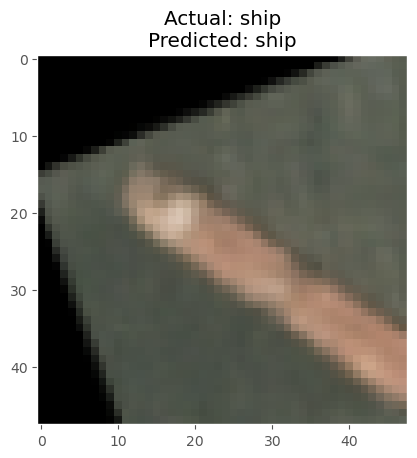

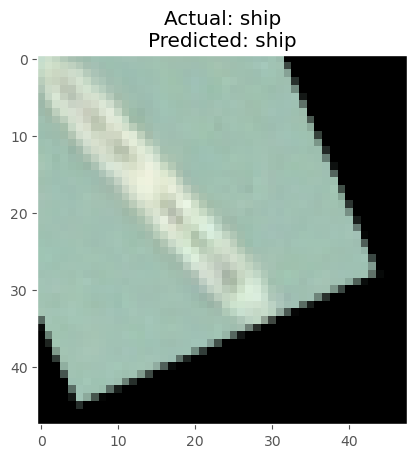

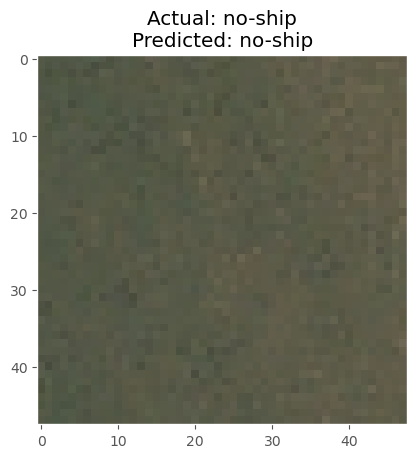

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


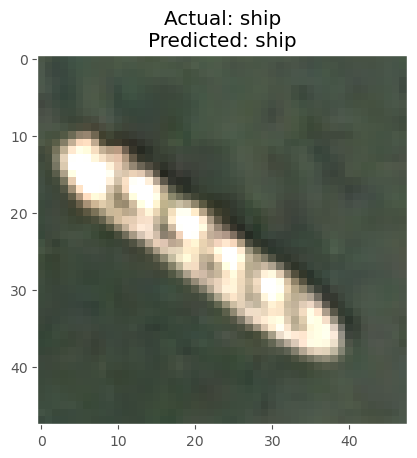

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


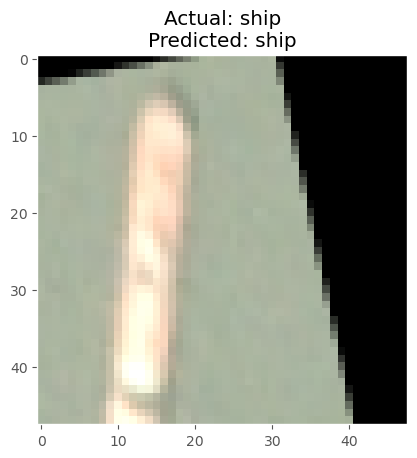

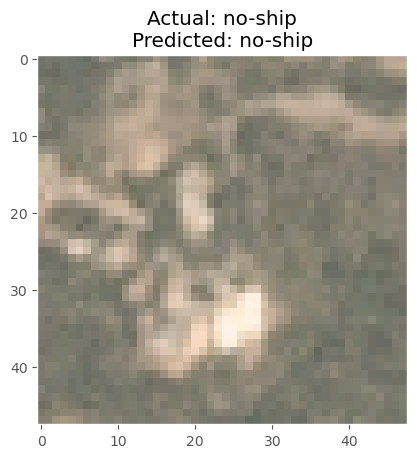

In [33]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):
    
    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

In [76]:
model.save("ship-model.h5")

C:\Users\carol\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
